<a href="https://colab.research.google.com/github/girlscodetoo-ch/AI-Arts/blob/main/IntroductionToAI/workshop_DE-Teil3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KS Stans Workshop - Künstliche Intelligenz und Kunst - Teil 4

Willkommen zum vierten teil des Kunst & Künstliche Intelligenz Workshop. In diesem so genannten _Notebook_ wirst du eine kurze Einführung in die Programmiersprache `Python` bekommen, wirst du erfahren, wie ein Computer Bilder sieht und lernen, wie man mit Künstlicher Intelligenz Kunst schaffen kann. Lasst uns loslegen!

## **Teil IV** - KI für die Kunst verwenden

## Breaking News! 

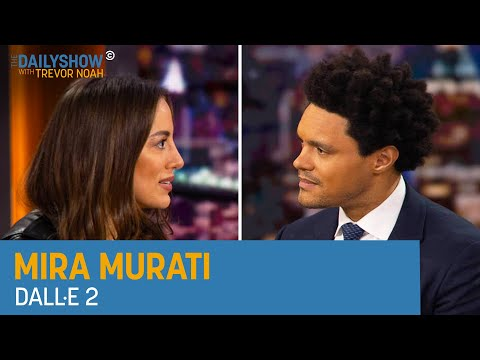

In [2]:
#@title
from IPython.display import YouTubeVideo
YouTubeVideo('Ba_C-C6UwlI', width=750, height=500)

# If link does not work try this one: https://www.youtube.com/watch?v=Ba_C-C6UwlI&ab_channel=TheDailyShowwithTrevorNoah

## Jetzt seid ihr dran! 

Eine der aufregendsten Entwicklungen im Bereich Deep Learning ist der künstlerische Stiltransfer (Neural Style Transfer auf Englisch), d.h. die Fähigkeit, ein neues Bild, ein sogenanntes Pastiche, auf der Grundlage von zwei Eingangsbildern zu erstellen: eines für den künstlerischen Stil und eines für den Inhalt.

![](https://github.com/girlscodetoo-ch/AI-Arts/blob/main/IntroductionToAI/images/pastiche.png?raw=1)

Die neuronale Stilübertragung ist eine Optimierungstechnik, bei der drei Bilder - ein Inhaltsbild, ein Stilreferenzbild (z. B. ein Kunstwerk eines berühmten Malers) und das Eingangsbild, das du stylen willst - miteinander vermischt werden, so dass das Eingangsbild so umgewandelt wird, dass es wie das Inhaltsbild aussieht, aber im Stil des Stilbildes "gemalt" ist.

Ist das Magie oder nur Deep Learning? Glücklicherweise handelt es sich dabei nicht um Magie: Die Stilübertragung ist eine lustige und interessante Technik, die die Fähigkeiten und internen Repräsentationen von neuronalen Netzen vorführt.

Das Prinzip des neuronalen Stiltransfers besteht darin, zwei Abstandsfunktionen zu definieren: eine, die beschreibt, wie unterschiedlich die Inhalte zweier Bilder sind, Lcontent, und eine, die den Unterschied zwischen den beiden Bildern in Bezug auf ihren Stil beschreibt, Lstyle. Bei drei Bildern, einem gewünschten Stilbild, einem gewünschten Inhaltsbild und dem Eingangsbild (das mit dem Inhaltsbild initialisiert wird), versuchen wir dann, das Eingangsbild so zu transformieren, dass der Abstand zwischen dem Inhaltsbild und dem Stilbild minimiert wird.
Zusammengefasst: Wir nehmen das Basis-Eingangsbild, ein Inhaltsbild, das wir abgleichen wollen, und das Stilbild, das wir abgleichen wollen. Wir wandeln das Basis-Eingangsbild um, indem wir die Abstände (Verluste) zwischen Inhalt und Stil mit Backpropagation minimieren und so ein Bild erzeugen, das dem Inhalt des Inhaltsbildes und dem Stil des Stilbildes entspricht.


### Den Tensorflow-Hub verwenden

TensorFlow Hub bietet nicht nur vortrainierte Programme, sondern auch eine ML-Programmier-Community mit einigen Lernkursen. Auf dieser Plattform können wir gemeinsam mehr über maschinelles Lernen lernen und diskutieren, und du bist herzlich eingeladen, deine Lernerfahrungen und Lernprogramme mit uns zu teilen.

Falls ihr folgendes Problem habt: 

`ModuleNotFoundError: No module named 'tensorflow_hub'` dann schreibt in die Zelle hier unten bitte: 

```!pip install tensorflow_hub```

#### Setup

Import dependencies.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

Download the content and style images, and the pre-trained TensorFlow Lite models.

In [ ]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

294912/284398 [===============================] - 0s 0us/step


#### Pre-process the inputs

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

In [ ]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


#### Visualize the inputs

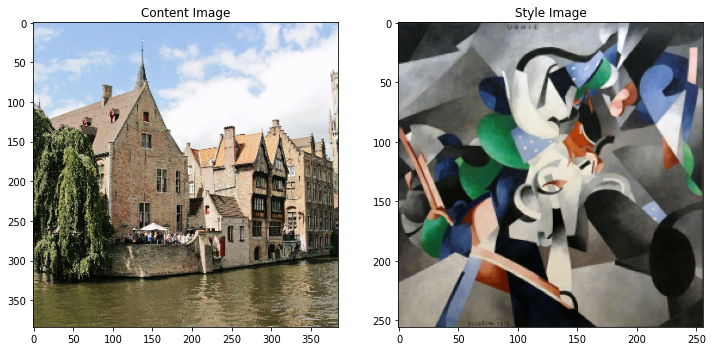

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

### Run style transfer with TensorFlow Lite

#### Style prediction

In [ ]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


#### Style transform

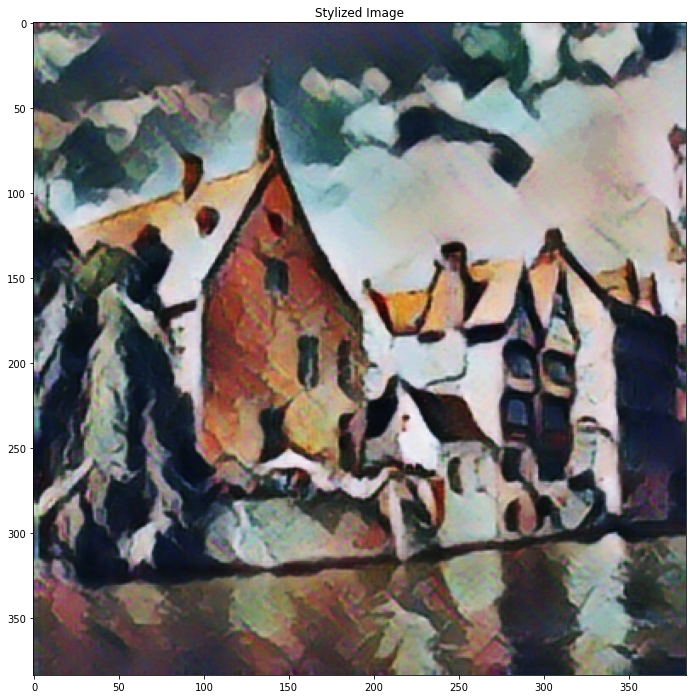

In [ ]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

#### Style blending

We can blend the style of content image into the stylized output, which in turn making the output look more like the content image.

In [ ]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

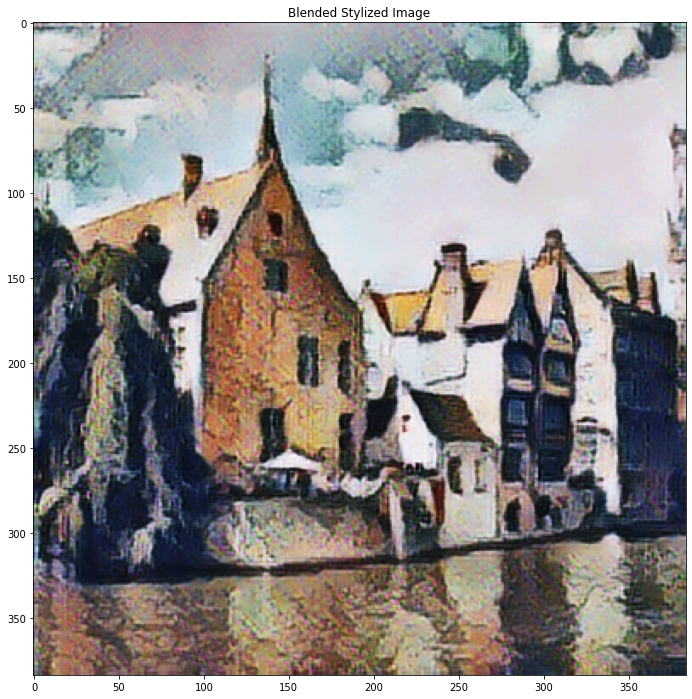

In [ ]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.24 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

# Et voilà! Ihr habt es geschafft! 

# Weitere Beispiele

Falls ihr noch nicht genug habt, könnte ihr auch gerne hier malreinschauen: 

- https://medium.com/@hannalee/art-creator-25fda3c35d8b
- https://medium.com/@ecyy/tensorflow-hub-create-an-artistic-picture-by-a-ml-app-e21308c7db1b

Viel Spass und vielen Dank, dass ihr bis zum Ende alles gegeben habt! 